In [1]:
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from matplotlib import pyplot as plt 

from pos_tagger import PosTagger
from attention_extraction import extract_all_attention, get_causal_selfattention_pattern
from data_handling import load_tinystories_data
from plotting import plot_probe_results_from_tag, plot_idx_of_highest_output, plot_selfattention_from_idx

data = load_tinystories_data('../data/tinystories_val.txt')


model_url = 'roneneldan/TinyStories-1M'

model = AutoModelForCausalLM.from_pretrained(model_url, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_url)

pos_tagger = PosTagger(tokenizer)

with open('../probe-results/results_keys.json', 'r') as file:
    results_key = json.load(file) 

with open('../probe-results/results_queries.json', 'r') as file:
    results_query = json.load(file) 

c:\Users\Bruger\Code\mechinterp\mechinterp\Lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [2]:
folder = '../figures/case_studies/quote_heads/'

## "is_in_quote"-head

Layer 2, head 0, is very active immediately after a start-quote. It attends back to the quote on all the proceeding tokens, untill the end quote, upon which it attends to itself. After the end-quote, it stops being active

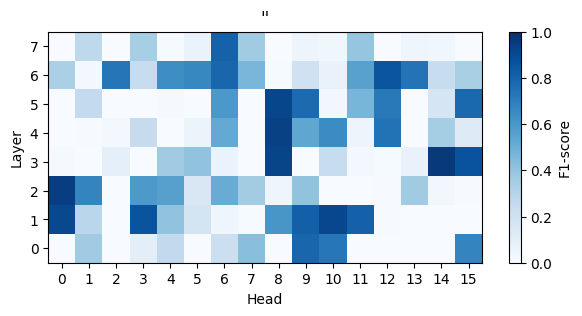

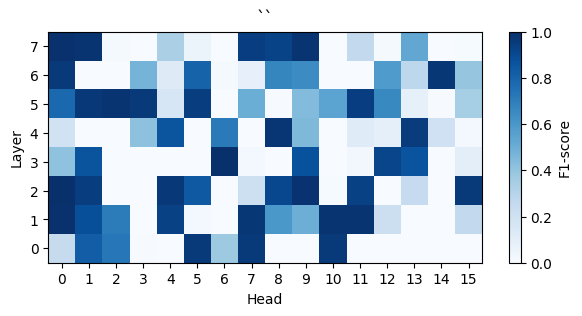

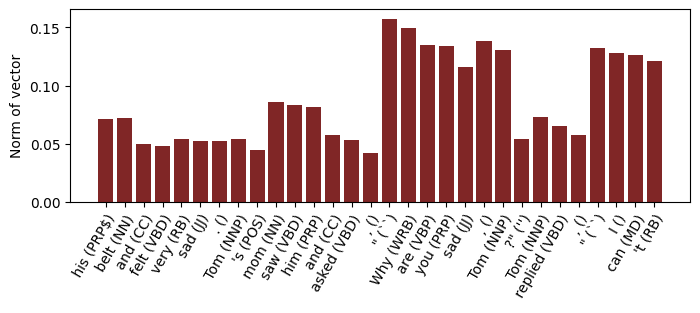

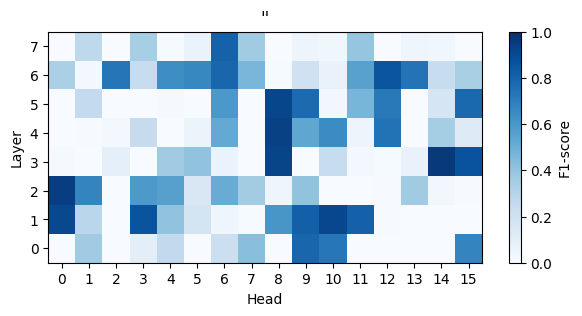

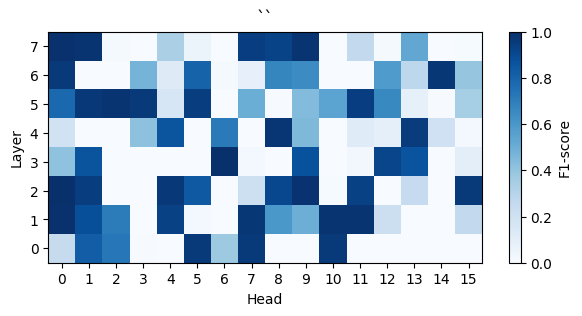

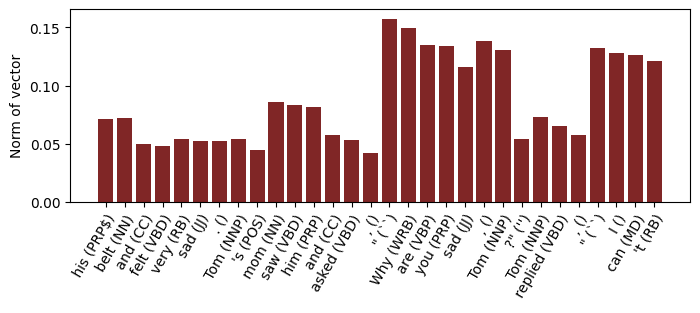

In [3]:
layer = 2
head = 0
input = data[10]

plot_probe_results_from_tag(results_key, '\'\'', cmap='Blues', outfile=folder + 'outquote.pdf')
plot_probe_results_from_tag(results_key, '``', cmap='Blues', outfile=folder+'inquote.pdf')

top_idx, fig, axs = plot_idx_of_highest_output(model, tokenizer, input, layer, head, pos_tagger, color=(0.5, 0.15, 0.15), outfile=folder+'quote_activity.pdf')


plot_probe_results_from_tag(results_key, '\'\'', cmap='Blues', outfile=folder + 'outquote.png')
plot_probe_results_from_tag(results_key, '``', cmap='Blues', outfile=folder+'inquote.png')

top_idx, fig, axs = plot_idx_of_highest_output(model, tokenizer, input, layer, head, pos_tagger, color=(0.5, 0.15, 0.15), outfile=folder+'quote_activity.png')

In [4]:
axs.get_xticklabels()

[Text(0, 0, ' his (PRP$)'),
 Text(1, 0, ' belt (NN)'),
 Text(2, 0, ' and (CC)'),
 Text(3, 0, ' felt (VBD)'),
 Text(4, 0, ' very (RB)'),
 Text(5, 0, ' sad (JJ)'),
 Text(6, 0, '. ()'),
 Text(7, 0, ' Tom (NNP)'),
 Text(8, 0, "'s (POS)"),
 Text(9, 0, ' mom (NN)'),
 Text(10, 0, ' saw (VBD)'),
 Text(11, 0, ' him (PRP)'),
 Text(12, 0, ' and (CC)'),
 Text(13, 0, ' asked (VBD)'),
 Text(14, 0, ', ()'),
 Text(15, 0, ' " (``)'),
 Text(16, 0, 'Why (WRB)'),
 Text(17, 0, ' are (VBP)'),
 Text(18, 0, ' you (PRP)'),
 Text(19, 0, ' sad (JJ)'),
 Text(20, 0, ', ()'),
 Text(21, 0, ' Tom (NNP)'),
 Text(22, 0, '?" (\'\')'),
 Text(23, 0, ' Tom (NNP)'),
 Text(24, 0, ' replied (VBD)'),
 Text(25, 0, ', ()'),
 Text(26, 0, ' " (``)'),
 Text(27, 0, 'I ()'),
 Text(28, 0, ' can (MD)'),
 Text(29, 0, "'t (RB)")]

In [5]:
for lab in axs.get_xticklabels():
    if lab.get_position()[0] in {15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29}:
        lab.set_fontweight('bold')
        lab.set_fontsize(10)
    else:
        lab.set_fontsize(10)


fig.savefig(folder + 'quote_activity.pdf', bbox_inches='tight')
fig.savefig(folder + 'quote_activity.png', bbox_inches='tight')

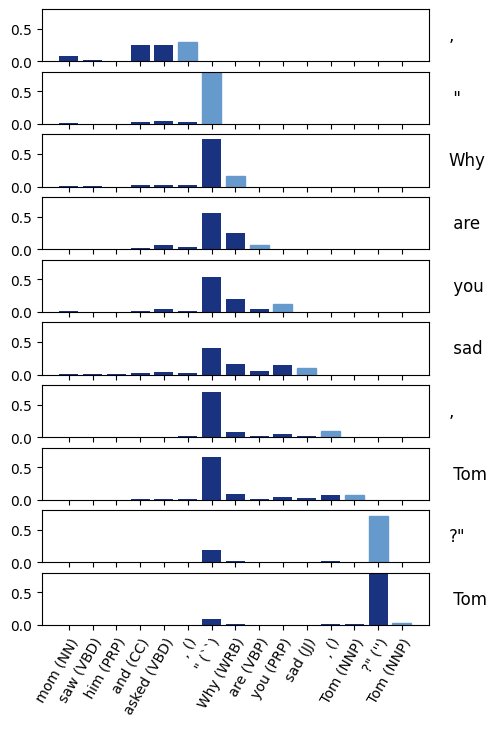

In [6]:


keys, queries, values = extract_all_attention(model, tokenizer, input)
attention = get_causal_selfattention_pattern(keys[layer][head], queries[layer][head])
tokens, tags, words = pos_tagger.tag_input(input, return_words=True)


# self attention

fig, axs = plt.subplots(10, 1, figsize=(5,8), sharex=True)
axs = axs.flatten()
top_idx = top_idx - 1
start_buffer = 5
start = top_idx - start_buffer


for idx, ax in enumerate(axs):
    i = idx
    idx += top_idx

    # ax.set_title(words[idx])

    ax.text(1.05, 0.5, words[idx], transform=ax.transAxes, rotation=0, 
            fontsize=12, va="center", ha="left")

    attn_context = attention[idx, start : top_idx + 10]
    words_context = words[start : top_idx + 10]
    tags_context = tags[start : top_idx + 10]

    barplot = [attn_context[j].item() for j in range(10 + start_buffer)]

    bars = ax.bar(range(start, top_idx + 10), barplot, color=(0.1, 0.2, 0.5))
    bars[i + start_buffer].set_color((0.4, 0.6, 0.8))
    ax.set_ylim((0, 0.8))
    ax.set_xticks(range(start, top_idx + 10))
    ax.set_xticklabels([f'{word} ({tag})' for word, tag in zip(words_context, tags_context)], rotation=60, ha='right', rotation_mode='anchor')

fig.savefig(folder + 'quote_attention.pdf', bbox_inches='tight')
fig.savefig(folder + 'quote_attention.png', bbox_inches='tight')